In [ ]:
!pip install ultralytics

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import shutil
import random

def split_dataset(folder_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Ensure ratios sum to 1
    if not (0 <= train_ratio <= 1 and 0 <= val_ratio <= 1 and 0 <= test_ratio <= 1):
        print("Error: Ratios must be between 0 and 1.")
        return
    if round(train_ratio + val_ratio + test_ratio, 2) != 1.0:
        print("Error: Ratios must sum to 1.")
        return

    # Define paths for train, val, and test directories
    splits = ['train', 'val', 'test']
    split_paths = {split: os.path.join(folder_path, split) for split in splits}

    # Create train, val, test directories if they don't exist
    for path in split_paths.values():
        os.makedirs(path, exist_ok=True)

    # List all images in the main folder
    all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if not all_files:
        print(f"Error: No images found in '{folder_path}'.")
        return

    # Shuffle the files for random distribution
    random.shuffle(all_files)

    # Calculate split sizes
    total_files = len(all_files)
    train_end = int(total_files * train_ratio)
    val_end = train_end + int(total_files * val_ratio)

    train_files = all_files[:train_end]
    val_files = all_files[train_end:val_end]
    test_files = all_files[val_end:]

    # Move files to respective folders
    for file in train_files:
        shutil.move(os.path.join(folder_path, file), os.path.join(split_paths['train'], file))
    for file in val_files:
        shutil.move(os.path.join(folder_path, file), os.path.join(split_paths['val'], file))
    for file in test_files:
        shutil.move(os.path.join(folder_path, file), os.path.join(split_paths['test'], file))

    print("Dataset successfully split into train, val, and test directories.")
    validate_split(folder_path)

def validate_split(folder_path):
    # Define paths for train, val, and test directories
    splits = ['train', 'val', 'test']
    split_paths = {split: os.path.join(folder_path, split) for split in splits}

    # Check existence of all folders
    for split, path in split_paths.items():
        if not os.path.exists(path):
            print(f"Error: '{split}' folder is missing in '{folder_path}'. Please create it and add images.")
            return

    # Count the number of files in each folder
    for split, path in split_paths.items():
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        print(f"{split.capitalize()} folder contains {len(files)} files.")
        if not files:
            print(f"Warning: The '{split}' folder is empty.")

# Usage
folder_path = '/content/drive/MyDrive/ANEMIA/Left_Fingernail_files/Images_left_fingernail'
split_dataset(folder_path)


In [ ]:
def run_segmentation_model(model_path, train_path, val_path, test_path):
  model = YOLO(model_path)
  results_train = model(train_path, save=True)
  results_val = model(val_path, save=True)
  results_test = model(test_path, save=True)
  return model, results_train, results_val, results_test

In [ ]:
import cv2
import os
import numpy as np

def created_model_input(results, target_size=(224, 224), max_palm_regions=1):
    """
    Processes YOLO segmentation results to extract and normalize palm regions.

    Args:
        results (list): List of YOLO prediction results.
        target_size (tuple): Desired size to resize the palm regions.
        max_palm_regions (int): Maximum number of palm regions to extract per image.

    Returns:
        dict: A dictionary mapping image names to lists of normalized palm regions.
    """
    palm_class = 2  # Update this if your palm class ID is different
    blue_circle_class_id = 1

    top_palm_bounds = {}
    normalized = {}
    normalized_padded = {}

    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path)
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes (x_min, y_min, x_max, y_max)
        scores = result.boxes.conf.cpu().numpy()  # Confidence scores
        classes = result.boxes.cls.cpu().numpy()  # Class IDs

        # Filter palm boxes
        palm_boxes = [
            (box, score) for box, score, cls in zip(boxes, scores, classes) if cls == palm_class
        ]
        # Sort by confidence and take the top N
        palm_boxes = sorted(palm_boxes, key=lambda x: x[1], reverse=True)[:max_palm_regions]
        top_palm_bounds[image_name] = palm_boxes

        normalized_images = []
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read image: {image_path}")
            continue

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect blue circle
        blue_circle_box = next(
            (
                box for box, cls in zip(boxes, classes)
                if cls == blue_circle_class_id
            ),
            None
        )
        if blue_circle_box is None:
            print(f"{image_name}: Blue circle not detected.")
            continue

        # Compute the center pixel value of the blue circle
        x_min_c, y_min_c, x_max_c, y_max_c = map(int, blue_circle_box)
        center_x = (x_min_c + x_max_c) // 2
        center_y = (y_min_c + y_max_c) // 2

        # Validate center coordinates
        if center_y >= image.shape[0] or center_x >= image.shape[1]:
            print(f"{image_name}: Blue circle center out of bounds.")
            continue

        center_pixel_value = image[center_y, center_x].astype(np.float32) + 1e-6  # Prevent division by zero

        # Normalize each palm bounding box
        for (box, score) in top_palm_bounds.get(image_name, []):
            x_min, y_min, x_max, y_max = map(int, box)
            # Ensure bounding box is within image dimensions
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image.shape[1], x_max)
            y_max = min(image.shape[0], y_max)

            if x_min >= x_max or y_min >= y_max:
                print(f"{image_name}: Invalid palm bounding box {x_min, y_min, x_max, y_max}. Skipping.")
                continue

            palm_region = image[y_min:y_max, x_min:x_max].astype(np.float32)

            # Normalize pixel values by center pigment
            normalized_palm = palm_region / center_pixel_value
            normalized_palm = np.clip(normalized_palm, 0, 1)  # Ensure values are within [0, 1]

            # Resize to target size
            normalized_palm_resized = cv2.resize(normalized_palm, target_size, interpolation=cv2.INTER_AREA)
            normalized_images.append(normalized_palm_resized)

        # Pad the list of normalized palms to ensure fixed size
        if len(normalized_images) == 0:
            print(f"{image_name}: No valid palm regions found after normalization.")
            continue

        while len(normalized_images) < max_palm_regions:
            normalized_images.append(normalized_images[-1])  # Duplicate the last image

        normalized_padded[image_name] = normalized_images[:max_palm_regions]

    return normalized_padded


In [ ]:
def obtain_hb_data(hb_file, sheet_name):
  hb_data = pd.read_excel(hb_file, sheet_name = sheet_name)
  return hb_data

In [ ]:
from torchvision import transforms

# Augmentations: Rotations, Cropping, Flips
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=(-30, 30)),  # Random rotations between -30 and 30 degrees
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Cropping (80-100%)
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip
    transforms.ToTensor()  # Convert to tensor
])

In [ ]:
import torch
from torchvision import transforms
def label_with_hb(fingernail_hb_data, normalized):
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
  ])

  inputs = []
  targets = []

  for _, row in fingernail_hb_data.iterrows():
    image_name = row['Left_Palm_Images'] #change to left palm image for single or right
    hb_value = torch.tensor(row['Hb_Value'], dtype=torch.float32)

    if image_name in normalized:
        images = normalized[image_name]
        combined_image = torch.cat([transform(img) for img in images], dim=2)
        inputs.append(combined_image)
        targets.append(hb_value)

  inputs = torch.stack(inputs)
  targets = torch.tensor(targets)

  return inputs, targets

In [ ]:
def convert_to_tensors(inputs, targets, batch_size, shuffle):
  data = torch.utils.data.TensorDataset(inputs, targets)
  loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffle)
  return data, loader

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
def regression_model_setup():
  class EfficientNet9ChannelsModel(nn.Module):
    def __init__(self, pretrained=True):
        super(EfficientNet9ChannelsModel, self).__init__()
        # Load the pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

        # Modify the first convolution layer to accept 3 input channels
        self.efficientnet.features[0][0] = nn.Conv2d(
            3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )

        # Add dropout to features for regularization
        self.dropout = nn.Dropout(p=0.3)  # Dropout with 30% probability

        # Modify the classifier to output 1 value (for regression)
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout with 50% probability before final layer
            nn.Linear(self.efficientnet.classifier[1].in_features, 1)
        )

    def forward(self, x):
        x = self.efficientnet.features(x)
        x = self.dropout(x)  # Apply dropout to the features
        x = self.efficientnet.avgpool(x)  # Use the pre-defined avgpool
        x = torch.flatten(x, 1)
        x = self.efficientnet.classifier(x)
        return x

  # class MobileNet9ChannelsModel(nn.Module):
  #   def __init__(self, pretrained=True):
  #       super(MobileNet9ChannelsModel, self).__init__()
  #       # Load the pre-trained MobileNetV2 model
  #       self.mobilenet = models.mobilenet_v2(pretrained=pretrained)

  #       self.mobilenet.features[0][0] = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

  #       self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.classifier[1].in_features, 1)

  #   def forward(self, x):
  #       return self.mobilenet(x)

  model = EfficientNet9ChannelsModel(pretrained=True) #MobileNet9ChannelsModel(pretrained=True)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

  return model, criterion, optimizer

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()
            targets = targets.float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                inputs = inputs.float()
                targets = targets.float()

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

In [ ]:
def test_model(model, test_loader, criterion, tolerance=0.5, display_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    all_targets = []
    all_predictions = []
    sample_count = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()
            targets = targets.float()

            outputs = model(inputs)
            predictions = outputs.view(-1) #squeeze()

            loss = criterion(predictions, targets)
            test_loss += loss.item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            if sample_count < display_samples:
                for i in range(len(targets)):
                    print(f"Sample {sample_count + 1}:")
                    print(f"  Predicted: {predictions[i].item():.4f}")
                    print(f"  Actual:    {targets[i].item():.4f}")
                    sample_count += 1
                    if sample_count >= display_samples:
                        break

    plt.scatter(all_targets, all_predictions, color='blue', label='Predicted vs Actual')
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color='red', linestyle='--', label='Perfect Prediction Line')
    plt.title("Regression: Actual vs Predicted Hb Values")
    plt.xlabel("Actual Hb Values")
    plt.ylabel("Predicted Hb Values")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)

    # Display results
    print(f"\nTest Loss: {test_loss / len(test_loader):.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    return {"mae": mae, "mse": mse, "r2": r2}

In [ ]:
from google.colab import drive
from ultralytics import YOLO
import pandas as pd
import torch
from torchvision import transforms
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
import zipfile


#drive.mount('/content/drive')
#folder_path = '/content/drive/MyDrive/ANEMIA/Left_Palm_files'
#model_path = '/content/drive/MyDrive/ANEMIA/Right_Palm_files/best.pt'

In [ ]:
model, results_train, results_val, results_test = run_segmentation_model('/content/drive/MyDrive/ANEMIA/Right_Palm_files/best.pt',
                                                            '/content/drive/MyDrive/ANEMIA/Left_Palm_files/train',
                                                            '/content/drive/MyDrive/ANEMIA/Left_Palm_files/val',
                                                            '/content/drive/MyDrive/ANEMIA/Left_Palm_files/test')
segmented_train_input = created_model_input(results_train)
segmented_val_input = created_model_input(results_val)
segmented_test_input = created_model_input(results_test)

hb_data = obtain_hb_data("/content/drive/MyDrive/ANEMIA/Anemia_dataset_train.xlsx", 'Left_Palm_Data')


image 1/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709617534838.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.4ms
image 2/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709619358067.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.3ms
image 3/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709620897092.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 17.6ms
image 4/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709621197474.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 14.8ms
image 5/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709622111640.jpg: 1024x1024 1 colorcard, 1 bluecircle, 2 palms, 13.4ms
image 6/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709622220187.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.4ms
image 7/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709623237829.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.3ms
image 8/272 /content/drive/MyDrive/ANEMIA/Left_Palm_f

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s]


Epoch [1/20], Loss: 58.4601
Validation Loss: 2633.8463
Epoch [2/20], Loss: 8.0596
Validation Loss: 57.7376
Epoch [3/20], Loss: 5.6868
Validation Loss: 20.5615
Epoch [4/20], Loss: 3.8165
Validation Loss: 3.4811
Epoch [5/20], Loss: 2.8314
Validation Loss: 3.0160
Epoch [6/20], Loss: 2.1139
Validation Loss: 4.1851
Epoch [7/20], Loss: 1.5298
Validation Loss: 4.3430
Epoch [8/20], Loss: 2.0301
Validation Loss: 3.5902
Epoch [9/20], Loss: 1.4560
Validation Loss: 4.3163
Epoch [10/20], Loss: 1.7110
Validation Loss: 3.6855
Epoch [11/20], Loss: 1.3605
Validation Loss: 4.0696
Epoch [12/20], Loss: 1.1870
Validation Loss: 5.7047
Epoch [13/20], Loss: 1.0450
Validation Loss: 4.0914
Epoch [14/20], Loss: 1.1585
Validation Loss: 3.7601
Epoch [15/20], Loss: 1.0281
Validation Loss: 4.2067
Epoch [16/20], Loss: 1.0249
Validation Loss: 3.5309
Epoch [17/20], Loss: 1.0316
Validation Loss: 3.9526
Epoch [18/20], Loss: 0.9404
Validation Loss: 3.4921
Epoch [19/20], Loss: 0.8707
Validation Loss: 3.9132
Epoch [20/20], 

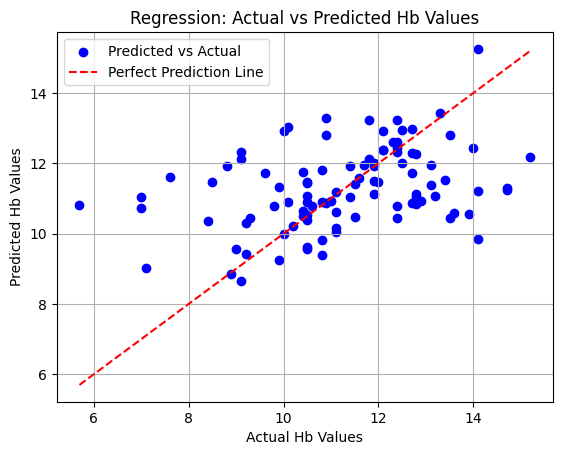


Test Loss: 3.0511
Mean Absolute Error (MAE): 1.2718
Mean Squared Error (MSE): 3.0511
R-squared (R²): 0.0828


In [ ]:
train_inputs, train_targets = label_with_hb(hb_data, segmented_train_input)
val_inputs, val_targets = label_with_hb(hb_data, segmented_val_input)
test_inputs, test_targets = label_with_hb(hb_data, segmented_test_input)

train_data, train_loader = convert_to_tensors(train_inputs, train_targets, batch_size=10, shuffle=True)
val_data, val_loader = convert_to_tensors(val_inputs, val_targets, batch_size=10, shuffle=True)
test_data, test_loader = convert_to_tensors(test_inputs, test_targets, batch_size=10, shuffle=True)

regression_model, criterion, optimizer = regression_model_setup()
train_model(regression_model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
metrics = test_model(regression_model, test_loader, criterion, display_samples=20)

In [ ]:
# Save the model state dictionary
torch.save(regression_model.state_dict(), "regression_model.pth")
print("Model saved as regression_model.pth")

Model saved as regression_model.pth


In [ ]:
# Function to determine the correct image column name based on sheet name
def get_image_column(sheet_name):
    if sheet_name == 'Left_Palm_Data':
        return 'Left_Palm_Images'
    elif sheet_name == 'Right_Palm_Data':
        return 'Palm_Images'  # Based on the data inspection
    else:
        raise ValueError(f"Unknown sheet name: {sheet_name}")

# Paths for left and right palm datasets
left_train_path = '/content/drive/MyDrive/ANEMIA/Left_Palm_files/train'
left_val_path = '/content/drive/MyDrive/ANEMIA/Left_Palm_files/val'
left_test_path = '/content/drive/MyDrive/ANEMIA/Left_Palm_files/test'

right_train_path = '/content/drive/MyDrive/ANEMIA/Right_Palm_files/train_all'
right_val_path = '/content/drive/MyDrive/ANEMIA/Right_Palm_files/val_all'
right_test_path = '/content/drive/MyDrive/ANEMIA/Right_Palm_files/test_all'

# Model path for segmentation
model_path = '/content/drive/MyDrive/ANEMIA/Right_Palm_files/best.pt'

# Segment left palm datasets
model, left_train_results, left_val_results, left_test_results = run_segmentation_model(
    model_path, left_train_path, left_val_path, left_test_path
)
left_segmented_train = created_model_input(left_train_results)
left_segmented_val = created_model_input(left_val_results)
left_segmented_test = created_model_input(left_test_results)

# Segment right palm datasets
model, right_train_results, right_val_results, right_test_results = run_segmentation_model(
    model_path, right_train_path, right_val_path, right_test_path
)
right_segmented_train = created_model_input(right_train_results)
right_segmented_val = created_model_input(right_val_results)
right_segmented_test = created_model_input(right_test_results)


image 1/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709617534838.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.3ms
image 2/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709619358067.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.4ms
image 3/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709620897092.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 24.2ms
image 4/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709621197474.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.4ms
image 5/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709622111640.jpg: 1024x1024 1 colorcard, 1 bluecircle, 2 palms, 13.4ms
image 6/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709622220187.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.3ms
image 7/272 /content/drive/MyDrive/ANEMIA/Left_Palm_files/train/1709623237829.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.3ms
image 8/272 /content/drive/MyDrive/ANEMIA/Left_Palm_f

In [ ]:
# Determine the appropriate image column dynamically
def get_image_column(data, possible_columns):
    for column in possible_columns:
        if column in data.columns:
            return column
    raise KeyError(f"None of the columns {possible_columns} found in the data.")

# Identify the correct image columns
left_image_column = get_image_column(hb_data_left, ['Palm_Images', 'Left_Palm_Images'])
right_image_column = get_image_column(hb_data_right, ['Palm_Images', 'Right_Palm_Images'])

# Debug: Print selected columns
print(f"Using '{left_image_column}' for Left Palm Data.")
print(f"Using '{right_image_column}' for Right Palm Data.")

# Process Left Palm data
left_train_inputs, left_train_targets = label_with_hb(hb_data_left.rename(columns={left_image_column: "Palm_Images"}), left_segmented_train)
left_val_inputs, left_val_targets = label_with_hb(hb_data_left.rename(columns={left_image_column: "Palm_Images"}), left_segmented_val)
left_test_inputs, left_test_targets = label_with_hb(hb_data_left.rename(columns={left_image_column: "Palm_Images"}), left_segmented_test)

# Process Right Palm data
right_train_inputs, right_train_targets = label_with_hb(hb_data_right.rename(columns={right_image_column: "Palm_Images"}), right_segmented_train)
right_val_inputs, right_val_targets = label_with_hb(hb_data_right.rename(columns={right_image_column: "Palm_Images"}), right_segmented_val)
right_test_inputs, right_test_targets = label_with_hb(hb_data_right.rename(columns={right_image_column: "Palm_Images"}), right_segmented_test)

# Combine inputs and targets from both sides
train_inputs = torch.cat((left_train_inputs, right_train_inputs), dim=0)
train_targets = torch.cat((left_train_targets, right_train_targets), dim=0)

val_inputs = torch.cat((left_val_inputs, right_val_inputs), dim=0)
val_targets = torch.cat((left_val_targets, right_val_targets), dim=0)

test_inputs = torch.cat((left_test_inputs, right_test_inputs), dim=0)
test_targets = torch.cat((left_test_targets, right_test_targets), dim=0)

# Convert labeled data to loaders
train_data, train_loader = convert_to_tensors(train_inputs, train_targets, batch_size=10, shuffle=True)
val_data, val_loader = convert_to_tensors(val_inputs, val_targets, batch_size=10, shuffle=True)
test_data, test_loader = convert_to_tensors(test_inputs, test_targets, batch_size=10, shuffle=True)

# Train the model
regression_model, criterion, optimizer = regression_model_setup()
train_model(regression_model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

# Test the model
metrics = test_model(regression_model, test_loader, criterion, display_samples=20)

# Output the metrics
print("Regression Model Metrics:", metrics)


NameError: name 'hb_data_left' is not defined

In [ ]:
# Dynamically find the correct column name (Palm_Images or side-specific column)
def get_image_column_or_default(data, side_specific_column, renamed_column="Palm_Images"):
    if side_specific_column in data.columns:
        return side_specific_column
    elif renamed_column in data.columns:
        return renamed_column
    else:
        raise KeyError(f"Neither '{side_specific_column}' nor '{renamed_column}' found in columns: {data.columns}")

# Load hemoglobin data for Left and Right Palms
hb_data_left = obtain_hb_data("/content/drive/MyDrive/ANEMIA/Anemia_dataset_train.xlsx", 'Left_Palm_Data')
hb_data_right = obtain_hb_data("/content/drive/MyDrive/ANEMIA/Anemia_dataset_train.xlsx", 'Right_Palm_Data')

# Standardize column names to remove leading/trailing spaces
hb_data_left.columns = hb_data_left.columns.str.strip()
hb_data_right.columns = hb_data_right.columns.str.strip()

# Remove duplicate columns
hb_data_left = hb_data_left.loc[:, ~hb_data_left.columns.duplicated()]
hb_data_right = hb_data_right.loc[:, ~hb_data_right.columns.duplicated()]

# Dynamically find the correct column names
left_image_column = get_image_column_or_default(hb_data_left, 'Left_Palm_Images')
right_image_column = get_image_column_or_default(hb_data_right, 'Right_Palm_Images')

# Rename the image columns to a consistent name 'Palm_Images'
hb_data_left = hb_data_left.rename(columns={left_image_column: 'Palm_Images'})
hb_data_right = hb_data_right.rename(columns={right_image_column: 'Palm_Images'})

# Debug: Verify renaming of columns
print("Columns in Left Palm Data after renaming:", hb_data_left.columns)
print("Columns in Right Palm Data after renaming:", hb_data_right.columns)


Columns in Left Palm Data after renaming: Index(['Unnamed: 0', 'Blood_Sample_ID', 'Palm_Images', 'Palm_Images',
       'Hb_Value', 'Gender', 'Age_in_years', 'Image_Path'],
      dtype='object')
Columns in Right Palm Data after renaming: Index(['Unnamed: 0', 'Palm_Images', 'Palm_Images', 'Blood_Sample_ID',
       'Hb_Value', 'Gender', 'Age_in_years', 'Image_Path'],
      dtype='object')


In [ ]:
# Imports
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

import cv2
import numpy as np
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def run_segmentation_model(model_path, train_path, val_path, test_path):
    model = YOLO(model_path)
    results_train = model(train_path, save=True)
    results_val = model(val_path, save=True)
    results_test = model(test_path, save=True)
    return model, results_train, results_val, results_test

def created_model_input(results, target_size=(224, 224), max_palm_regions=1):
    """
    Processes YOLO segmentation results to extract and normalize palm regions.

    Args:
        results (list): List of YOLO prediction results.
        target_size (tuple): Desired size to resize the palm regions.
        max_palm_regions (int): Maximum number of palm regions to extract per image.

    Returns:
        dict: A dictionary mapping image names to lists of normalized palm regions.
    """
    palm_class = 2  # Update this if your palm class ID is different
    blue_circle_class_id = 1

    top_palm_bounds = {}
    normalized = {}
    normalized_padded = {}

    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path)
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes (x_min, y_min, x_max, y_max)
        scores = result.boxes.conf.cpu().numpy()  # Confidence scores
        classes = result.boxes.cls.cpu().numpy()  # Class IDs

        # Filter palm boxes
        palm_boxes = [
            (box, score) for box, score, cls in zip(boxes, scores, classes) if cls == palm_class
        ]
        # Sort by confidence and take the top N
        palm_boxes = sorted(palm_boxes, key=lambda x: x[1], reverse=True)[:max_palm_regions]
        top_palm_bounds[image_name] = palm_boxes

        normalized_images = []
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read image: {image_path}")
            continue

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect blue circle
        blue_circle_box = next(
            (
                box for box, cls in zip(boxes, classes)
                if cls == blue_circle_class_id
            ),
            None
        )
        if blue_circle_box is None:
            print(f"{image_name}: Blue circle not detected.")
            continue

        # Compute the center pixel value of the blue circle
        x_min_c, y_min_c, x_max_c, y_max_c = map(int, blue_circle_box)
        center_x = (x_min_c + x_max_c) // 2
        center_y = (y_min_c + y_max_c) // 2

        # Validate center coordinates
        if center_y >= image.shape[0] or center_x >= image.shape[1]:
            print(f"{image_name}: Blue circle center out of bounds.")
            continue

        center_pixel_value = image[center_y, center_x].astype(np.float32) + 1e-6  # Prevent division by zero

        # Normalize each palm bounding box
        for (box, score) in top_palm_bounds.get(image_name, []):
            x_min, y_min, x_max, y_max = map(int, box)
            # Ensure bounding box is within image dimensions
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image.shape[1], x_max)
            y_max = min(image.shape[0], y_max)

            if x_min >= x_max or y_min >= y_max:
                print(f"{image_name}: Invalid palm bounding box {x_min, y_min, x_max, y_max}. Skipping.")
                continue

            palm_region = image[y_min:y_max, x_min:x_max].astype(np.float32)

            # Normalize pixel values by center pigment
            normalized_palm = palm_region / center_pixel_value
            normalized_palm = np.clip(normalized_palm, 0, 1)  # Ensure values are within [0, 1]

            # Resize to target size
            normalized_palm_resized = cv2.resize(normalized_palm, target_size, interpolation=cv2.INTER_AREA)
            normalized_images.append(normalized_palm_resized)

        # Pad the list of normalized palms to ensure fixed size
        if len(normalized_images) == 0:
            print(f"{image_name}: No valid palm regions found after normalization.")
            continue

        while len(normalized_images) < max_palm_regions:
            normalized_images.append(normalized_images[-1])  # Duplicate the last image

        normalized_padded[image_name] = normalized_images[:max_palm_regions]

    return normalized_padded

def obtain_hb_data(hb_file, sheet_name):
    hb_data = pd.read_excel(hb_file, sheet_name=sheet_name)
    return hb_data

# Augmentations: Rotations, Cropping, Flips
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=(-30, 30)),  # Random rotations between -30 and 30 degrees
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Cropping (80-100%)
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip
    transforms.ToTensor()  # Convert to tensor
])

def label_with_hb(hb_data, normalized, image_column_name):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])

    inputs = []
    targets = []

    for _, row in hb_data.iterrows():
        image_name = row[image_column_name]  # Use the parameterized column name
        hb_value = torch.tensor(row['Hb_Value'], dtype=torch.float32)

        if image_name in normalized:
            images = normalized[image_name]
            combined_image = torch.cat([transform(img) for img in images], dim=2)
            inputs.append(combined_image)
            targets.append(hb_value)

    inputs = torch.stack(inputs)
    targets = torch.tensor(targets)

    return inputs, targets

def convert_to_tensors(inputs, targets, batch_size, shuffle):
    data = torch.utils.data.TensorDataset(inputs, targets)
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffle)
    return data, loader

def regression_model_setup():
    class EfficientNet9ChannelsModel(nn.Module):
        def __init__(self, pretrained=True):
            super(EfficientNet9ChannelsModel, self).__init__()
            # Load the pre-trained EfficientNet model
            self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

            # Modify the first convolution layer to accept 3 input channels
            self.efficientnet.features[0][0] = nn.Conv2d(
                3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
            )

            # Add dropout to features for regularization
            self.dropout = nn.Dropout(p=0.3)  # Dropout with 30% probability

            # Modify the classifier to output 1 value (for regression)
            self.efficientnet.classifier = nn.Sequential(
                nn.Dropout(p=0.5),  # Dropout with 50% probability before final layer
                nn.Linear(self.efficientnet.classifier[1].in_features, 1)
            )

        def forward(self, x):
            x = self.efficientnet.features(x)
            x = self.dropout(x)  # Apply dropout to the features
            x = self.efficientnet.avgpool(x)  # Use the pre-defined avgpool
            x = torch.flatten(x, 1)
            x = self.efficientnet.classifier(x)
            return x

    model = EfficientNet9ChannelsModel(pretrained=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    return model, criterion, optimizer

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()
            targets = targets.float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                inputs = inputs.float()
                targets = targets.float()

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

def test_model(model, test_loader, criterion, tolerance=0.5, display_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    all_targets = []
    all_predictions = []
    sample_count = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()
            targets = targets.float()

            outputs = model(inputs)
            predictions = outputs.view(-1)  # .squeeze()

            loss = criterion(predictions, targets)
            test_loss += loss.item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            if sample_count < display_samples:
                for i in range(len(targets)):
                    print(f"Sample {sample_count + 1}:")
                    print(f"  Predicted: {predictions[i].item():.4f}")
                    print(f"  Actual:    {targets[i].item():.4f}")
                    sample_count += 1
                    if sample_count >= display_samples:
                        break

    plt.scatter(all_targets, all_predictions, color='blue', label='Predicted vs Actual')
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color='red', linestyle='--', label='Perfect Prediction Line')
    plt.title("Regression: Actual vs Predicted Hb Values")
    plt.xlabel("Actual Hb Values")
    plt.ylabel("Predicted Hb Values")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)

    # Display results
    print(f"\nTest Loss: {test_loss / len(test_loader):.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    return {"mae": mae, "mse": mse, "r2": r2}

# Define the body part you're working with
body_part = 'Palm'  # Change this to 'Eye', 'Fingernail', or 'Tongue' as needed

# Define the base path
base_path = '/content/drive/MyDrive/course data/output_images'

# Construct data paths
train_path = os.path.join(base_path, body_part, 'Train')
val_path = os.path.join(base_path, body_part, 'Val')
test_path = os.path.join(base_path, body_part, 'Test')

# Define the model path
model_path = '/content/drive/MyDrive/ANEMIA/Right_Palm_files/best.pt'

# Mapping for sheet names and image column names based on the body part
body_part_to_sheet_name = {
    'Palm': 'Left_Palm_Data',
    'Eye': 'Eye_Data',
    'Fingernail': 'Finger_Nail_Data',
    'Tongue': 'Tongue_Data'
}

body_part_to_image_column = {
    'Palm': 'Left_Palm_Images',
    'Eye': 'Eye_Images',
    'Fingernail': 'Left_Finger_Nail_Images',
    'Tongue': 'Tongue_Images'
}

# Get the sheet name and image column name based on the body part
sheet_name = body_part_to_sheet_name[body_part]
image_column_name = body_part_to_image_column[body_part]

# Obtain Hb data
hb_file = '/content/drive/MyDrive/ANEMIA/Anemia_dataset_train.xlsx'
hb_data = obtain_hb_data(hb_file, sheet_name)

# Run the segmentation model
model, results_train, results_val, results_test = run_segmentation_model(
    model_path,
    train_path,
    val_path,
    test_path
)

# Create model inputs
segmented_train_input = created_model_input(results_train)
segmented_val_input = created_model_input(results_val)
segmented_test_input = created_model_input(results_test)

# Label the data with Hb values
train_inputs, train_targets = label_with_hb(hb_data, segmented_train_input, image_column_name)
val_inputs, val_targets = label_with_hb(hb_data, segmented_val_input, image_column_name)
test_inputs, test_targets = label_with_hb(hb_data, segmented_test_input, image_column_name)

# Convert to tensors and create data loaders
train_data, train_loader = convert_to_tensors(train_inputs, train_targets, batch_size=10, shuffle=True)
val_data, val_loader = convert_to_tensors(val_inputs, val_targets, batch_size=10, shuffle=True)
test_data, test_loader = convert_to_tensors(test_inputs, test_targets, batch_size=10, shuffle=True)

# Set up the regression model
regression_model, criterion, optimizer = regression_model_setup()

# Train the model
train_model(regression_model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

# Test the model
metrics = test_model(regression_model, test_loader, criterion, display_samples=20)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

image 1/438 /content/drive/MyDrive/course data/output_images/Palm/Train/1709617292291.jpg: 1024x1024 1 colorcard, 1 bluecircle, 2 palms, 14.6ms
image 2/438 /content/drive/MyDrive/course data/output_images/Palm/Train/1709618528581.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.5ms
image 3/438 /content/drive/MyDrive/course data/output_images/Palm/Train/1709619811692.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.4ms
image 4/438 /content/drive/MyDrive/course data/output_images/Palm/Train/1709619908813.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.4ms
image 5/438 /content/drive/MyDrive/course data/output_images/Palm/Train/1709620330090.jpg: 1024x1024 1 colorcard, 1 bluecircle, 2 palms, 14.8ms
image 6/438 /content/drive/MyDrive/course data/output_images/Palm/Train/1709620390303.jpg: 1024x1024 1 colorcard, 1 bluecircle, 2 palms, 13.4ms
image 7/4

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to evaluate metrics
def evaluate_model(model, test_loader, device):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).cpu().numpy()
            predictions = model(inputs).cpu().numpy()
            all_targets.extend(targets)
            all_predictions.extend(predictions)

    # Convert to numpy arrays
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    # Print results
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    return mae, mse, rmse, r2

# Directory to save models
model_save_dir = "/content/trained_models"
os.makedirs(model_save_dir, exist_ok=True)

# Run experiments
results = []  # To store results for each experiment

for exp in experiments:
    print(f"\nRunning Experiment: {exp}")
    model, criterion, optimizer = regression_model_setup(exp["model"], learning_rate=exp["lr"])
    train_loader = DataLoader(train_dataset, batch_size=exp["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=exp["batch_size"], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=exp["batch_size"], shuffle=False)

    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, exp["epochs"], device)

    # Test the model
    test_model(model, test_loader, criterion, device)

    # Evaluate metrics
    print(f"\nEvaluating Experiment: {exp}")
    mae, mse, rmse, r2 = evaluate_model(model, test_loader, device)

    # Save model
    model_path = os.path.join(model_save_dir, f"{exp['model']}_epochs{exp['epochs']}_lr{exp['lr']}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Store results
    results.append({
        "Experiment": exp,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Print summary of results
print("\nSummary of Results:")
for res in results:
    print(f"Experiment: {res['Experiment']}, MAE: {res['MAE']:.4f}, MSE: {res['MSE']:.4f}, "
          f"RMSE: {res['RMSE']:.4f}, R²: {res['R²']:.4f}")



Running Experiment: {'model': 'mobilenet', 'epochs': 20, 'lr': 0.001, 'batch_size': 16}


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Train Loss: 23.4124, Val Loss: 17.6575
Epoch [2/20], Train Loss: 5.7913, Val Loss: 5.7921
Epoch [3/20], Train Loss: 5.1045, Val Loss: 6.6163
Epoch [4/20], Train Loss: 5.0110, Val Loss: 6.2996
Epoch [5/20], Train Loss: 4.6058, Val Loss: 8.4074
Epoch [6/20], Train Loss: 4.1705, Val Loss: 7.0711
Epoch [7/20], Train Loss: 2.8258, Val Loss: 6.9003
Epoch [8/20], Train Loss: 2.9482, Val Loss: 8.2350
Epoch [9/20], Train Loss: 2.4918, Val Loss: 9.9492
Epoch [10/20], Train Loss: 1.9229, Val Loss: 7.7008
Epoch [11/20], Train Loss: 1.6631, Val Loss: 6.4880
Epoch [12/20], Train Loss: 1.1654, Val Loss: 6.1582
Epoch [13/20], Train Loss: 0.9924, Val Loss: 6.0905
Epoch [14/20], Train Loss: 0.9642, Val Loss: 6.4334
Epoch [15/20], Train Loss: 0.8105, Val Loss: 6.6221
Epoch [16/20], Train Loss: 0.7177, Val Loss: 6.0258
Epoch [17/20], Train Loss: 0.8951, Val Loss: 6.7220
Epoch [18/20], Train Loss: 0.8995, Val Loss: 5.7623
Epoch [19/20], Train Loss: 0.8134, Val Loss: 5.9376
Epoch [20/20], Trai

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 22.3294, Val Loss: 13.4874
Epoch [2/50], Train Loss: 5.8154, Val Loss: 8.1018
Epoch [3/50], Train Loss: 5.5046, Val Loss: 6.3773
Epoch [4/50], Train Loss: 4.7792, Val Loss: 9.0740
Epoch [5/50], Train Loss: 3.6755, Val Loss: 7.4949
Epoch [6/50], Train Loss: 3.3820, Val Loss: 7.7902
Epoch [7/50], Train Loss: 2.2826, Val Loss: 7.5923
Epoch [8/50], Train Loss: 2.3937, Val Loss: 8.1076
Epoch [9/50], Train Loss: 1.9659, Val Loss: 6.7579
Epoch [10/50], Train Loss: 1.8237, Val Loss: 7.1122
Epoch [11/50], Train Loss: 1.5909, Val Loss: 5.8832
Epoch [12/50], Train Loss: 1.1326, Val Loss: 7.0357
Epoch [13/50], Train Loss: 0.9675, Val Loss: 6.1288
Epoch [14/50], Train Loss: 0.6545, Val Loss: 7.0321
Epoch [15/50], Train Loss: 0.7834, Val Loss: 6.3109
Epoch [16/50], Train Loss: 0.6092, Val Loss: 6.0746
Epoch [17/50], Train Loss: 0.7574, Val Loss: 6.5366
Epoch [18/50], Train Loss: 0.6270, Val Loss: 6.4114
Epoch [19/50], Train Loss: 0.8905, Val Loss: 6.5075
Epoch [20/50], Trai

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 96.7668, Val Loss: 77.6530
Epoch [2/100], Train Loss: 56.0266, Val Loss: 43.1469
Epoch [3/100], Train Loss: 28.1612, Val Loss: 17.0628
Epoch [4/100], Train Loss: 11.8117, Val Loss: 10.2369
Epoch [5/100], Train Loss: 4.3326, Val Loss: 5.4879
Epoch [6/100], Train Loss: 2.2010, Val Loss: 5.9901
Epoch [7/100], Train Loss: 1.3286, Val Loss: 6.8077
Epoch [8/100], Train Loss: 1.1641, Val Loss: 5.8612
Epoch [9/100], Train Loss: 0.7742, Val Loss: 5.8080
Epoch [10/100], Train Loss: 0.9019, Val Loss: 5.5123
Epoch [11/100], Train Loss: 0.8338, Val Loss: 4.9383
Epoch [12/100], Train Loss: 0.9384, Val Loss: 5.2601
Epoch [13/100], Train Loss: 0.8052, Val Loss: 5.5744
Epoch [14/100], Train Loss: 0.9106, Val Loss: 5.0863
Epoch [15/100], Train Loss: 0.9866, Val Loss: 5.6360
Epoch [16/100], Train Loss: 0.8744, Val Loss: 5.2297
Epoch [17/100], Train Loss: 0.8349, Val Loss: 5.5683
Epoch [18/100], Train Loss: 0.8687, Val Loss: 5.8386
Epoch [19/100], Train Loss: 0.9243, Val Loss: 5

In [ ]:
# BASELINE MODEL PERFORMANCES

def mean_baseline_metrics_v2(data_dir, excel_path, body_part, split, sheet_name):
    """
    Dynamically calculates Mean Baseline metrics for a given body part and split.
    """
    # Load the Excel file
    labels_df = pd.read_excel(excel_path, sheet_name=sheet_name)

    # Filter for the specific split
    split_dir = os.path.join(data_dir, body_part, split)
    if not os.path.exists(split_dir):
        print(f"Directory {split_dir} does not exist.")
        return

    # Collect labels and predictions
    true_labels = []
    for image_file in os.listdir(split_dir):
        if image_file.endswith(('.jpg', '.png')):
            matching_row = labels_df[labels_df['Image_Path'].str.contains(image_file, na=False)]
            if not matching_row.empty:
                true_labels.append(matching_row.iloc[0]['Hb_Value'])

    if not true_labels:
        print(f"No matching labels found for {split} in {body_part}.")
        return

    # Dynamically calculate mean prediction
    mean_prediction = np.mean(true_labels)
    mean_predictions = [mean_prediction] * len(true_labels)

    # Calculate metrics
    mae = mean_absolute_error(true_labels, mean_predictions)
    mse = mean_squared_error(true_labels, mean_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_labels, mean_predictions)

    # Print metrics
    print(f"Metrics for {body_part} ({split} Split):")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2: {r2:.4f}")
    print("-" * 40)



# Paths and Configurations
data_dir = "/content/drive/MyDrive/course data/output_images"
excel_path = "/content/drive/MyDrive/ANEMIA/Anemia_dataset_train.xlsx"

# Body Parts and Splits
body_parts = {
    "Fingernail": ["Right_Finger_Nail_Data", "Left_Finger_Nail_Data"],
    "Palm": ["Right_Palm_Data", "Left_Palm_Data"],
    "Eye": ["Right_Eye_Data", "Left_Eye_Data"],
    "Tongue": ["Tongue_Data"]
}
splits = ["Train", "Val", "Test"]

# Run for each body part and split
for body_part, sheets in body_parts.items():
    for sheet in sheets:
        for split in splits:
            mean_baseline_metrics_v2(data_dir, excel_path, body_part, split, sheet)


Metrics for Fingernail (Train Split):
MAE: 1.4879
MSE: 3.4446
RMSE: 1.8560
R^2: 0.0000
----------------------------------------
Metrics for Fingernail (Val Split):
MAE: 1.6581
MSE: 3.7863
RMSE: 1.9458
R^2: 0.0000
----------------------------------------
Metrics for Fingernail (Test Split):
MAE: 1.4876
MSE: 3.0329
RMSE: 1.7415
R^2: 0.0000
----------------------------------------
Metrics for Fingernail (Train Split):
MAE: 1.5012
MSE: 3.5921
RMSE: 1.8953
R^2: 0.0000
----------------------------------------
Metrics for Fingernail (Val Split):
MAE: 1.6577
MSE: 3.8079
RMSE: 1.9514
R^2: 0.0000
----------------------------------------
Metrics for Fingernail (Test Split):
MAE: 1.4574
MSE: 2.9907
RMSE: 1.7294
R^2: 0.0000
----------------------------------------
Metrics for Palm (Train Split):
MAE: 1.5462
MSE: 3.5172
RMSE: 1.8754
R^2: 0.0000
----------------------------------------
Metrics for Palm (Val Split):
MAE: 1.5741
MSE: 3.6857
RMSE: 1.9198
R^2: 0.0000
-------------------------------------